In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import sys
parentDir = Path.cwd().parent
sys.path.insert(0, str(parentDir))
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
epoch_data_path = parentDir / "data/processed/ninapro_ex1_win200_ms_step50_ms.npz"
save_figs = True

In [3]:
data = np.load(epoch_data_path)

X = data['X']
y = data['y']
subject_ids = data['subject_ids']
rep_ids = data['rep_ids']
t0 = data['t0']
coverage = data['coverage']
Fs = data['Fs']
n_channels = data['n_channels']
L = data['L']
Ld = data['Ld']
T_ms = data['T_ms']
S_ms = data['S_ms']
gesture_ids_all = data['gesture_ids_all']
exercise_number = data['exercise_number']
include_rest = data['include_rest']
majority_threshold = data['majority_threshold']

In [4]:
print(f"Data shape: X={X.shape}, y={y.shape}, rep_ids={rep_ids.shape}, subject_ids={subject_ids.shape}")
print(f"Unique gestures: {np.unique(y)}")
print(f"Unique subjects: {np.unique(subject_ids)}")
print(f"Unique repetitions: {np.unique(rep_ids)}")

Data shape: X=(690099, 12, 400), y=(690099,), rep_ids=(690099,), subject_ids=(690099,)
Unique gestures: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Unique subjects: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Unique repetitions: [0 1 2 3 4 5 6]


### Decicde goals
- goal: cross-subject generalization: train on some subjects, test on held-out subjects
- task: 17-class gesture classification (labels 1...17)

In [5]:
from utils.ml_helpers import set_seeds, get_device
set_seeds(42)
device = get_device()

In [6]:
# Remove rest class (0)
rest_class = 0
select_class_mask = (y != rest_class)
X = X[select_class_mask]
y = y[select_class_mask]
subject_ids = subject_ids[select_class_mask]
rep_ids = rep_ids[select_class_mask]

In [11]:
# splot data for train, test, validation based on subject id
train_percent = 0.7
test_percent = 0.15
val_percent = 0.15

unique_subjects = np.unique(subject_ids)
n_subjects = len(unique_subjects)

n_train = int(n_subjects * train_percent)
n_test = int(n_subjects * test_percent)

# shuffle subjects
shuffled_subjects = unique_subjects.copy()
np.random.shuffle(shuffled_subjects)

train_subjects = shuffled_subjects[:n_train]
test_subjects = shuffled_subjects[n_train:n_train+n_test]
val_subjects = shuffled_subjects[n_train+n_test:]
print(f"Train subjects: {train_subjects}")
print(f"Test subjects: {test_subjects}")
print(f"Validation subjects: {val_subjects}")

# Set train, test, val indices
train_indices = np.isin(subject_ids, train_subjects)
test_indices = np.isin(subject_ids, test_subjects)
val_indices = np.isin(subject_ids, val_subjects)

# X_train, y_train = X[train_indices], y[train_indices]
# X_test, y_test = X[test_indices], y[test_indices]
# X_val, y_val = X[val_indices], y[val_indices]


Train subjects: [20 17 16 27  5 13 38 28 40  7 26 10 14 32 35  9 18 25  1 34  6 12  2 30
 22  3 31 37]
Test subjects: [ 4 36 24 33 11 23]
Validation subjects: [19 21  8 15 29 39]


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
class Standardize1D:
    def __init__(self, mean, std):
        self.mean, self.std = mean, std
    def __call__(self, x):
        return (x-self.mean)/self.std

In [18]:
from torch.utils.data import Dataset
class EMGDataset(Dataset):
    def __init__(self,X,y,transform=None):
        self.X=X # keeping as np arrays to save RAM copies
        self.y=y
        self.transform = transform
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self,idx):
        x = torch.from_numpy(self.X[idx]).float() #(C,L)
        y = torch.as_tensor(self.y[idx]).long()
        return x,y


In [ ]:
X_train = X[train_indices]
channel_means_tensor = torch.tensor(X_train.mean(axis=(0,2)), dtype=torch.float32)[:, None]
channel_stds_tensor = torch.tensor(X_train.std(axis=(0,2)).clip(min=1e-8), dtype=torch.float32)[:, None]


# Build dataset with train stats
# 
normalize = Standardize1D(channel_means_tensor, channel_stds_tensor)
train_ds = EMGDataset(X_train, y[train_indices], transform=normalize)
val_ds   = EMGDataset(X[val_indices],  y[val_indices], transform=normalize)
test_ds  = EMGDataset(X[test_indices], y[test_indices], transform=normalize)

In [ ]:
num_classes = len(np.unique(y))
n_channels, len_of_samples = X_train.shape[1], X_train.shape[2]
print("X shape:", X_train.shape, "| n_channels,len_of_samples=", n_channels, len_of_samples)

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
class CNN_model(nn.Module):
    """One layer CNN model for EMG:  (B, 12, 400) -> (B, numClasses)
    Conv1d -> BatchNor -> ReLU -> Dropout -> global avg pool -> Linear
    """
    def __init__(self, inChannels:int = 12, numClasses:int = 17, conv1out: int = 64, kernel_size: int = 31, p_dropout: float = 0.2):
        """Arguments:
        inChannels: number of input channels (EMG electrodes)
        numClasses: number of output classes (gestures)
        conv1out: number of filters identified. lower number to reduce overfitting or increase for underfitting
        kernel_size: kernel size or temporal receptive field in samples
        p_dropout: dropout probability"""
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=inChannels, out_channels=conv1out, kernel_size=kernel_size, padding=kernel_size//2)
        self.batchnorm1 = nn.BatchNorm1d(conv1out)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=p_dropout)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1) # output size (B, conv1out, 1) so for each filter we have 1 value
        self.fc = nn.Linear(conv1out, numClasses) # final classification layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.global_avg_pool(x) # (B, conv1out, 1)
        x = x.squeeze(-1)           # (B, conv1out)
        x = self.fc(x)              # (B, numClasses)
        return x

def accuracy(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()


In [113]:
# One loop of training
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train() # Set model to training mode
    running_loss, running_acc, n = 0.0, 0.0, 0
    for batch, (X, y) in enumerate(train_loader): # Loop over batches
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True) # clears old gradients from the last batch

        # Forward pass
        logits = model(X)
        loss = loss_fn(logits, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        batch_size = X.size(0)
        running_loss += loss.item() * batch_size
        running_acc += accuracy(logits, y) * batch_size
        n += batch_size

        return running_loss / n, running_acc / n


# One loop of validation
def validate_one_epoch(model, val_loader, loss_fn, device):
    model.eval() # Set model to evaluation mode
    running_loss, running_acc, n = 0.0, 0.0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)

            batch_size = X.size(0)
            running_loss += loss.item() * batch_size
            running_acc += accuracy(logits, y) * batch_size
            n += batch_size

    return running_loss / n, running_acc / n

def get_lrs(optimizer):
    return [pg["lr"] for pg in optimizer.param_groups]

In [160]:
# Initialize all hyperparameters in one place
batch_size = 128
num_epochs = 100
learning_rate = 0.001
kernel_size = 31
conv1out = 128
p_dropout = 0.2

In [161]:
import time
import json

# describe this run
hparams = dict(
    model="CNN_model",
    in_ch=n_channels, num_classes=num_classes,
    conv_out=conv1out, kernel_size=kernel_size, p_drop=p_dropout,
    lr=learning_rate, batch_size=batch_size, epochs=num_epochs, seed=42,
    notes="baseline one-layer cnn"
)

# unique run id
run_id = time.strftime("%Y%m%d-%H%M%S")
run_name = f"{hparams['model']}_k{hparams['kernel_size']}_f{hparams['conv_out']}_lr{hparams['lr']}_bs{hparams['batch_size']}_{run_id}"
run_dir = parentDir/"models"/run_name
run_dir.mkdir(parents=True, exist_ok=True)

# save config
with open(run_dir/"config.json","w") as f:
    json.dump(hparams, f, indent=2)

In [162]:

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [163]:
model = CNN_model(inChannels=n_channels, numClasses=num_classes, kernel_size=kernel_size, conv1out=conv1out, p_dropout=p_dropout)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5, min_lr=1e-5)
print(model)

CNN_model(
  (conv1): Conv1d(12, 128, kernel_size=(31,), stride=(1,), padding=(15,))
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=17, bias=True)
)


In [164]:
from pathlib import Path
best_ckpt = run_dir/"best.pt"
last_ckpt = run_dir/"last.pt"


history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

best_val_acc = 0.0
bad_epochs = 0
patience = 10
ckpt_path = "smallcnn1d_best.pt"


for epoch in range(num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    va_loss, va_acc = validate_one_epoch(model, val_loader, loss_fn, device)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    # LR scheduler step
    scheduler.step(va_acc)
    current_lrs = get_lrs(optimizer)[0]
    history["lr"].append(current_lrs)

    print(f"Epoch {epoch+1:03d} | "
        f"train: {tr_loss:.4f}/{tr_acc:.3f} | "
        f"val: {va_loss:.4f}/{va_acc:.3f} | "
        f"lr: {current_lrs:.2e}")

    # save 'last' every epoch
    torch.save({
        "epoch": epoch+1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "history": history,
        "hparams": {"lr": learning_rate, "batch_size": batch_size}
    }, last_ckpt)

    # save 'best' when val_acc improves (and reset early-stop counter)
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        bad_epochs = 0
        torch.save(torch.load(last_ckpt), best_ckpt)
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping (no val acc improvement for {patience} epochs).")
            break

# Load best before test/plots
best = torch.load(best_ckpt, map_location=device)
model.load_state_dict(best["model_state"])


Epoch 001 | train: 2.7306/0.047 | val: 2.6806/0.070 | lr: 1.00e-03
Epoch 002 | train: 2.5379/0.109 | val: 2.6373/0.105 | lr: 1.00e-03
Epoch 003 | train: 2.6414/0.188 | val: 2.5997/0.135 | lr: 1.00e-03
Epoch 004 | train: 2.6310/0.148 | val: 2.5630/0.177 | lr: 1.00e-03
Epoch 005 | train: 2.5219/0.180 | val: 2.5298/0.200 | lr: 1.00e-03
Epoch 006 | train: 2.5501/0.203 | val: 2.5024/0.212 | lr: 1.00e-03
Epoch 007 | train: 2.4835/0.219 | val: 2.4803/0.221 | lr: 1.00e-03
Epoch 008 | train: 2.4386/0.156 | val: 2.4618/0.223 | lr: 1.00e-03
Epoch 009 | train: 2.3911/0.281 | val: 2.4470/0.221 | lr: 1.00e-03
Epoch 010 | train: 2.4062/0.211 | val: 2.4341/0.221 | lr: 1.00e-03
Epoch 011 | train: 2.4369/0.234 | val: 2.4223/0.224 | lr: 1.00e-03
Epoch 012 | train: 2.3444/0.188 | val: 2.4094/0.227 | lr: 1.00e-03
Epoch 013 | train: 2.3474/0.250 | val: 2.3973/0.228 | lr: 1.00e-03
Epoch 014 | train: 2.3437/0.273 | val: 2.3851/0.231 | lr: 1.00e-03
Epoch 015 | train: 2.4535/0.242 | val: 2.3749/0.233 | lr: 1.00

<All keys matched successfully>

In [165]:
import pandas as pd
epochs = range(1, len(history["train_loss"])+1)
pd.DataFrame({
    "epoch": epochs,
    "train_loss": history["train_loss"],
    "val_loss": history["val_loss"],
    "train_acc": history["train_acc"],
    "val_acc": history["val_acc"],
    "lr": history["lr"],
}).to_csv(f"{run_dir}/training_history.csv", index=False)

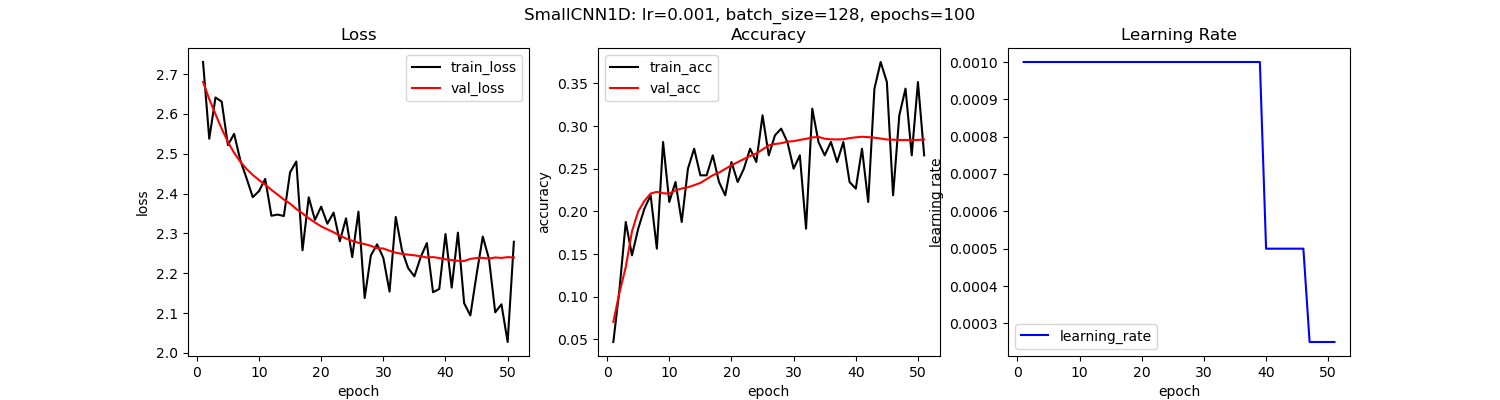

In [166]:
%matplotlib widget
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"])+1)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(epochs, history["train_loss"], label="train_loss", color='black')
axs[0].plot(epochs, history["val_loss"],   label="val_loss", color='red')
axs[0].set_xlabel("epoch"); axs[0].set_ylabel("loss"); axs[0].legend(); axs[0].set_title("Loss")

axs[1].plot(epochs, history["train_acc"], label="train_acc", color='black')
axs[1].plot(epochs, history["val_acc"],   label="val_acc", color='red')
axs[1].set_xlabel("epoch"); axs[1].set_ylabel("accuracy"); axs[1].legend(); axs[1].set_title("Accuracy")

axs[2].plot(epochs, history["lr"], label="learning_rate", color='blue')
axs[2].set_xlabel("epoch"); axs[2].set_ylabel("learning rate")
axs[2].legend(); axs[2].set_title("Learning Rate")
# Set title with hyperparameters
plt.suptitle(f"SmallCNN1D: lr={learning_rate}, batch_size={batch_size}, epochs={num_epochs}")
if save_figs:
    plt.savefig(f"{run_dir}/cnn_training_curve_{learning_rate}_{batch_size}_{num_epochs}.png")
    # Save history
    np.savez(f"{run_dir}/cnn_training_history_{learning_rate}_{batch_size}_{num_epochs}.npz", **history)
plt.show()
